## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [213]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, spacy, stop words and English language model
from string import punctuation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer, LatentDirichletAllocation, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image, en_core_web_sm, scattertext, WordCloud, STOPWORDS, ImageColorGenerator, 
from PIL import Image
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix




In [132]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [133]:
congress_tweets=congress_tweets.drop(['tweet_id', 'screen_name'],axis=1)

In [134]:
congress_tweets

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946786,2020-12-25T08:15:00-05:00,"From our family to yours, we wish you a very M...",Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"
946787,2020-12-25T09:04:53-05:00,Bobbi and I wish everyone a wonderful Christma...,John Barrasso,Sen,3-Jan-19,7/21/1952,M,WY,Senate,Republican,"174,419","55,973","69,286","170,962"
946788,2020-12-28T11:20:02-05:00,God bless the six brave law enforcement office...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"
946789,2021-01-01T08:15:00-05:00,Wishing a healthy and very happy New Year to e...,Liz Cheney,Rep,3-Jan-17,7/28/1966,F,WY,0,Republican,"174,419","55,973","69,286","170,962"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [135]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith(('http', 'RT'))]
    
    #spacy_words2 = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [136]:
text = congress_tweets['text'][2]

In [137]:
tokens_reduced = rem_punc_stop(text)
tokens_reduced

['senatemajldr',
 'Democrats',
 'border',
 'security',
 'government',
 'funding',
 'agreement',
 'pass',
 'House',
 'earn',
 '60',
 'votes',
 'Senate',
 'receive',
 'presidential',
 'signature',
 'All',
 'things',
 'needed',
 'One',
 'partisan',
 'vote',
 'House',
 'wo',
 'nt',
 'solve']

In [138]:
numpy.random.seed(10)
ct_sub = congress_tweets.sample(n=3000)

In [139]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911"
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431"
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688"


In [140]:
ct_sub['tokens'] = ct_sub['text'].map(lambda x: rem_punc_stop(x))
ct_sub['tokens']

36257     [Before, adopting, Olivia, spent, great, time,...
548996    [Are, supposed, Trump, seriously, literally, s...
652347    [Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...
267614    [Made, remarks, AmFreeSyria, sharing, concern,...
344386    [jeroneanderson, MontcoLP, LelandShow, realDon...
                                ...                        
289949    [That, reason, I, proud, secured, provisions, ...
590720    [We, need, funds, EIDL, meantime, SBAGov, queu...
601127    [A, strong, US, economic, recovery, underway, ...
264039    [The, Savannah, Harbor, Expansion, Project, tr...
720271    [RIHEALTH, GovRaimondo, All, customerfacing, b...
Name: tokens, Length: 3000, dtype: object

In [196]:
ct_sub['tokens_str'] = ct_sub['tokens'].map(lambda text: ' '.join(text))

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered <u>word frequencies,</u> <u>word clouds,</u> <u>word/character counts,</u> <u>scattertext,</u> and <u>topic modeling</u> as possible exploration tools. 

### EDA 1 - Word Cloud

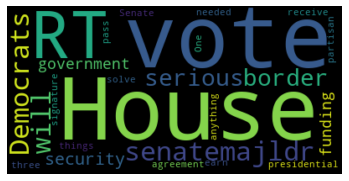

In [142]:
wordtext = ' '.join(ct_sub['tokens'].map(lambda wordtext: ' '.join(wordtext)))
wordcloud = WordCloud().generate(text)
ct_sub['wordcloud'] = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show() 

We noticed that RT appeared in the word cloud but RT refers to retweet and won't help us with analysis so we're going to adjust the rem_punc_stop function to remove the word from all tweets.

In [143]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    nlp.Defaults.stop_words.add("RT")
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

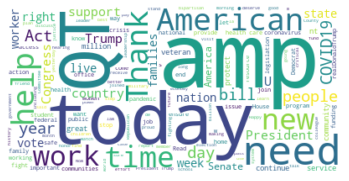

In [144]:
ct_sub['tokens'] = ct_sub['text'].map(lambda x: rem_punc_stop(x))
text = ' '.join(ct_sub['tokens'].map(lambda text: ' '.join(text)))

wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 2 - Topic Modeling 

#### Part 1: 5 components

In [145]:
#create  tf-idf matrix
X = ct_sub['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense() 

In [146]:
#apply LDA model with hyperparameter n_components = 5
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [147]:
#print topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [148]:
#print top words
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:


 
 rt amp trump today qt country president people women   ” “ new covid19 time nt de thank

Topic #1:


 amp rt 
   energy today covid19 qt support time thank need congress help health new work great people

Topic #2:


 
 rt amp today   act president need covid19 american 🚨 trump qt americans america people help house support

Topic #3:


 amp rt health 
 president people today act   trump qt senate house care public bill impeachment time need

Topic #4:


 rt amp 
 today   house bill american act trump help people need qt president work — vote ”



In [149]:
#compare prevalence of each topic across documents

#get topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.87627324, 0.03076924, 0.03046008, 0.0317393 , 0.03075814],
       [0.80283226, 0.04896441, 0.04935409, 0.04958278, 0.04926647],
       [0.04822139, 0.80778762, 0.04814834, 0.0478427 , 0.04799994],
       ...,
       [0.03779254, 0.84826675, 0.03800228, 0.03799192, 0.0379465 ],
       [0.04489783, 0.04401416, 0.04429207, 0.82272008, 0.04407586],
       [0.03869828, 0.03773846, 0.03700416, 0.03743357, 0.84912552]])

In [150]:
#merge back with original df
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(ct_sub.reset_index())
df_w_topics.head()

,0,1,2,3,4,index,datetime,text,name_wikipedia,position,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud
0,0.876273,0.030769,0.030460,0.031739,0.030758,36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,...,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
1,0.802832,0.048964,0.049354,0.049583,0.049266,548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,...,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
2,0.048221,0.807788,0.048148,0.047843,0.048000,652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,...,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
3,0.033706,0.033933,0.864157,0.034015,0.034189,267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,...,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
4,0.054063,0.783212,0.054353,0.054256,0.054116,344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,...,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x7fa...


In [151]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x7fa...


In [152]:
#check average weight of each topic across party using group by
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat       0.210456
Republican     0.191270
Independent    0.103631
Name: 0, dtype: float64
party
Republican     0.199675
Democrat       0.169458
Independent    0.162353
Name: 1, dtype: float64
party
Independent    0.226032
Republican     0.216877
Democrat       0.204266
Name: 2, dtype: float64
party
Independent    0.289216
Democrat       0.230060
Republican     0.211500
Name: 3, dtype: float64
party
Independent    0.218768
Democrat       0.185760
Republican     0.180678
Name: 4, dtype: float64


In [153]:
#check average weight of each topic across position using group by
grouped = df_w_topics.groupby('position')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

position
Sen    0.208265
Rep    0.201637
Name: 0, dtype: float64
position
Sen    0.185174
Rep    0.178564
Name: 1, dtype: float64
position
Rep    0.211657
Sen    0.199655
Name: 2, dtype: float64
position
Sen    0.223840
Rep    0.223717
Name: 3, dtype: float64
position
Rep    0.184425
Sen    0.183066
Name: 4, dtype: float64


<b> What do we see so far? </b>
With n_components = 5, we don't really see much separation for either party or position.  Going to retrain LDA with more topics, n_topics = 10. 

### EDA 2 - Topic Modeling 

#### Part 2: 10 components

In [154]:
#apply LDA model with hyperparameter n_components = 10
lda_10 = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda_10 = lda_10.fit(dense_matrix)

In [155]:
#print topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [156]:
#print top words
tf_feature_names = tf.get_feature_names()
print_top_words(lda_10, tf_feature_names, 20)


Topic #0:


 
 rt amp trump women today “   people new qt ” president care health act country support year

Topic #1:


 amp rt   
 de energy trump today – president support great senate covid19 time work la need house

Topic #2:


 
   amp rt today american health need house help people time president realdonaldtrump community join americans new covid19

Topic #3:


 amp rt 
 qt house president   health help today people bill time continue public work trump congress workers

Topic #4:


 rt amp   want president today help bill 
 trump qt covid19 ️ bipartisan work — new house care

Topic #5:
rt amp 

 
   today health congress country workers protect day families covid19 act care businesses veterans qt need

Topic #6:


 
 rt amp today need act nt qt time — trump house coronavirus help covid19 bill president ” federal

Topic #7:


 rt amp 
 president today ✅ health workers veterans need realdonaldtrump trump qt   covid19 like great care ”

Topic #8:
amp 

 today rt people american qt 

In [157]:
#compare prevalence of each topic across documents

#get topic distribution array
topic_dist = lda_10.transform(tfidf_matrix)
topic_dist

array([[0.01497638, 0.86518763, 0.01497757, ..., 0.01497705, 0.01497463,
        0.01498091],
       [0.78108657, 0.02432395, 0.02432412, ..., 0.02432342, 0.02432286,
        0.02432485],
       [0.02362394, 0.02362248, 0.02362234, ..., 0.02362264, 0.78739742,
        0.02362197],
       ...,
       [0.01859476, 0.01859324, 0.01859418, ..., 0.01859612, 0.33400744,
        0.01859383],
       [0.02172395, 0.02171902, 0.02171803, ..., 0.02172564, 0.02171992,
        0.02171866],
       [0.83616156, 0.01820411, 0.01820315, ..., 0.01820392, 0.01820233,
        0.01820738]])

In [158]:
#merge back with original df
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(ct_sub.reset_index())
df_w_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud
0,0.014976,0.865188,0.014978,0.014992,0.014980,0.014975,0.014979,0.014977,0.014975,0.014981,...,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
1,0.781087,0.024324,0.024324,0.024323,0.024323,0.024323,0.024325,0.024323,0.024323,0.024325,...,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
2,0.023624,0.023622,0.023622,0.023622,0.023622,0.023623,0.023622,0.023623,0.787397,0.023622,...,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
3,0.016744,0.016744,0.016747,0.016747,0.016745,0.016745,0.016748,0.016744,0.016745,0.849291,...,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x7fa...
4,0.026860,0.758257,0.026859,0.026863,0.026860,0.026860,0.026860,0.026859,0.026863,0.026859,...,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x7fa...


In [159]:
#check average weight of each topic across party using group by
grouped = df_w_topics.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat       0.104063
Republican     0.098032
Independent    0.018151
Name: 0, dtype: float64
party
Democrat       0.106380
Republican     0.104468
Independent    0.082282
Name: 1, dtype: float64
party
Republican     0.099703
Democrat       0.097597
Independent    0.018152
Name: 2, dtype: float64
party
Independent    0.142481
Republican     0.117021
Democrat       0.102601
Name: 3, dtype: float64
party
Republican     0.100410
Democrat       0.095560
Independent    0.018152
Name: 4, dtype: float64
party
Republican     0.100082
Democrat       0.094618
Independent    0.018151
Name: 5, dtype: float64
party
Democrat       0.106617
Republican     0.091303
Independent    0.080636
Name: 6, dtype: float64
party
Independent    0.330232
Republican     0.093011
Democrat       0.088516
Name: 7, dtype: float64
party
Independent    0.147095
Republican     0.097835
Democrat       0.097255
Name: 8, dtype: float64
party
Independent    0.144668
Democrat       0.106794
Republican     0.098135
Name

In [160]:
#check average weight of each topic across position using group by
grouped = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.103834
Sen    0.094180
Name: 0, dtype: float64
position
Sen    0.106955
Rep    0.105179
Name: 1, dtype: float64
position
Sen    0.102016
Rep    0.096757
Name: 2, dtype: float64
position
Rep    0.111108
Sen    0.097422
Name: 3, dtype: float64
position
Sen    0.103166
Rep    0.095019
Name: 4, dtype: float64
position
Rep    0.099504
Sen    0.085594
Name: 5, dtype: float64
position
Sen    0.110628
Rep    0.098135
Name: 6, dtype: float64
position
Rep    0.094321
Sen    0.080905
Name: 7, dtype: float64
position
Sen    0.103453
Rep    0.095892
Name: 8, dtype: float64
position
Sen    0.115683
Rep    0.100251
Name: 9, dtype: float64


<b>What do we see?</b>
Still don't see much separation for either party or position. While the number of topics produced are sensitive to our choice of n, it doesn't seem like choosing more topics did any better in separating out topics by Congressional party or position. Feels like all Congressional members, irrespective of party and position seem to be having discussions around similar topics.  The ways they discuss these topics may differ, and it might be that sentiment analysis will do a better job picking up these difference of opinions. 

### EDA 3 - Word Count

In [161]:
ct_sub['word_count'] = ct_sub['text'].apply(lambda x: len(str(x).split()))

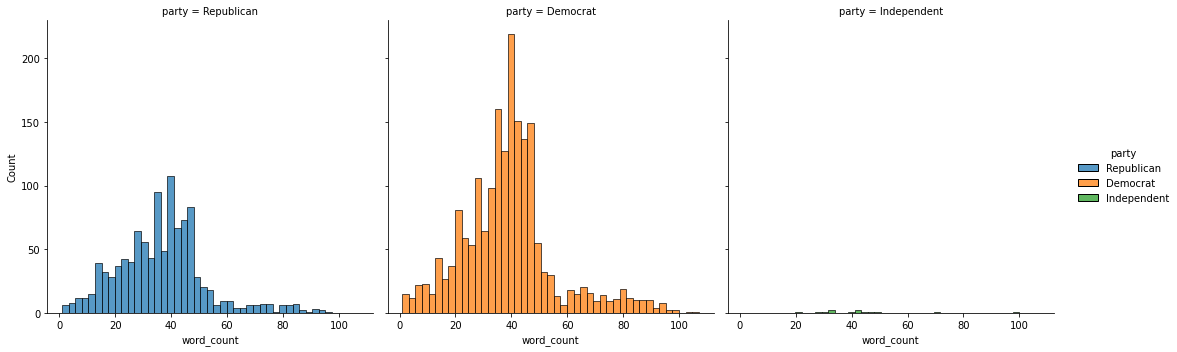

In [162]:
#for party
sns.displot(ct_sub, x="word_count", hue = "party", col = "party")
plt.show()

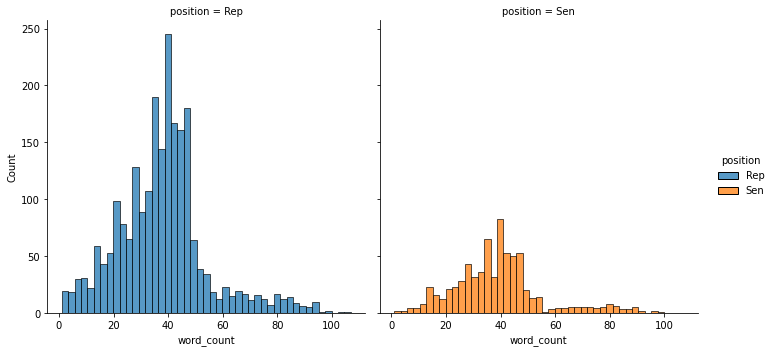

In [163]:
#for position
sns.displot(ct_sub, x="word_count", hue = "position", col = "position")
plt.show()

<b>What do we see?</b>
Democrats and Representatives have higher word count relative to their comparative counterparts (Republicans, and Senators, respectively). This might influence the results we see in the sentiment analysis and beyond.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [164]:
# Sen. Nydia Velázquez (D) vs. Sen. Liz Cheney (R)

velázquez_text = congress_tweets[congress_tweets['name_wikipedia']=='Nydia Velázquez']['text']
velázquez_text

cheney_text = congress_tweets[congress_tweets['name_wikipedia']=='Liz Cheney']['text']
cheney_text

944272    Rep. Liz Cheney: "What's Immoral Is Not To Sec...
944273    RT @ThisWeekABC Rep. Liz Cheney says Speaker o...
944274    @hellafree19 @RedBankIrish Thanks very much. W...
944275    ICYMI: I joined @ThisWeekABC to discuss the De...
944278    I was honored to be at @Mark_Gordon_WY inaugur...
                                ...                        
946783    It’s been nearly two weeks since the American ...
946784    Today's announcement on the Record of Decision...
946786    From our family to yours, we wish you a very M...
946788    God bless the six brave law enforcement office...
946789    Wishing a healthy and very happy New Year to e...
Name: text, Length: 640, dtype: object

#### Sentiment

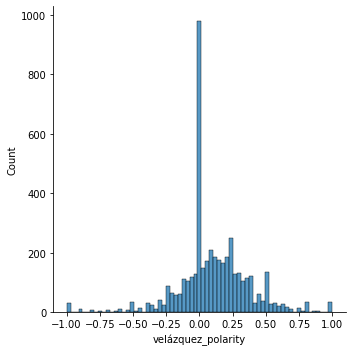

In [165]:
congress_tweets['velázquez_polarity']= velázquez_text.map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x='velázquez_polarity')
plt.show()

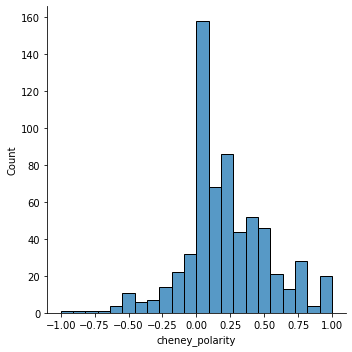

In [166]:
congress_tweets['cheney_polarity']= cheney_text.map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x='cheney_polarity')
plt.show()

<b>What do we see?</b>
According to the plots, both Senators' tweets are mostly nuetral. This matches what I'd assume, given that politicians tend to stay away from polarizing statements.

#### Subjectivity

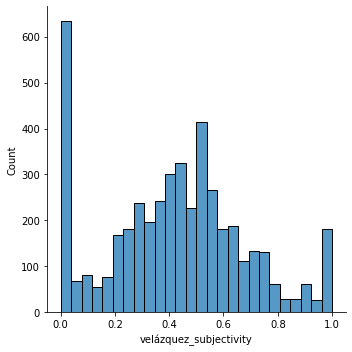

In [167]:
congress_tweets['velázquez_subjectivity'] = velázquez_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="velázquez_subjectivity")
plt.show()

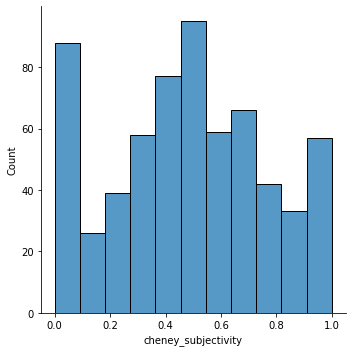

In [168]:
congress_tweets['cheney_subjectivity'] = cheney_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="cheney_subjectivity")
plt.show()

<b>What do we see?</b>
According to the plots, Senator Velázquez's tweets tend to be more objective. A significant portion of Senator Cheney's tweet are also objective, however Senator Cheney seems to have a mean closer to ~0.5. This may suggest that Democratic senators are more objective, however it may also be due to the much smaller sample from Senator Cheney.

#### Sentiment vs. Subjectivity

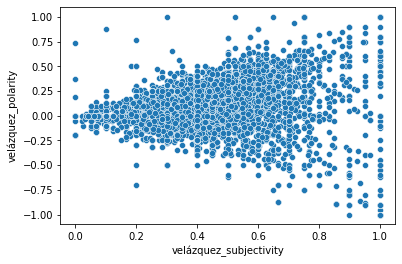

In [169]:
sns.scatterplot(data = congress_tweets, x = 'velázquez_subjectivity', y = 'velázquez_polarity')
plt.show()

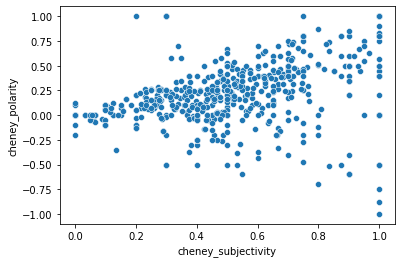

In [170]:
sns.scatterplot(data = congress_tweets, x = 'cheney_subjectivity', y = 'cheney_polarity')
plt.show()

<b>What do we see?</b>
According to the plots, both Senators' tweets become more polarizing as they become more subjective. In the case of Senator Cheney, however, this occurs in a much more positive direction than Senator Velázquez. This, again, may be due to the smaller sample size from Senator Cheney.

#### Democrats vs. Republicans

In [171]:
ct_sub['polarity']= ct_sub['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
ct_sub['subjectivity']= ct_sub['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)

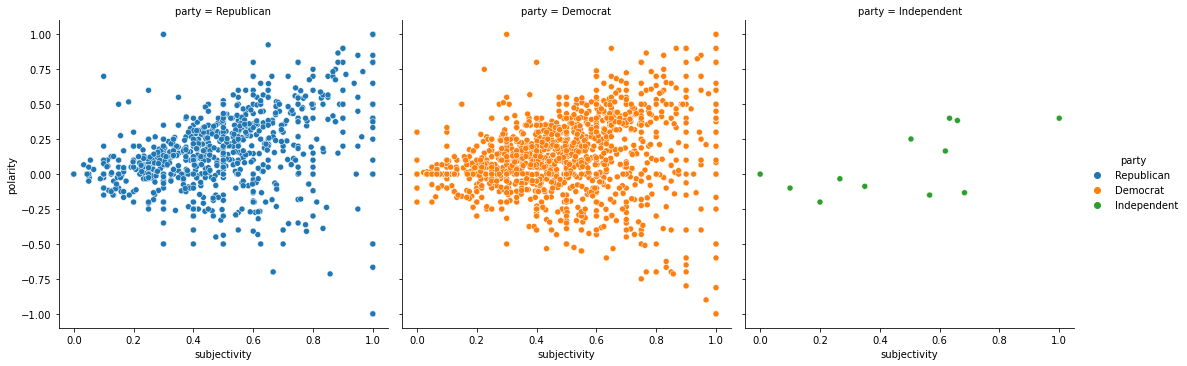

In [172]:
sns.relplot(
    data=ct_sub, x="subjectivity", y="polarity",
    col="party", hue = "party", kind="scatter"
)
plt.show()

<b>What do we see?</b>
These plots reveal a similar patter to the one we just saw between Senators Velázquez and Cheney. It seems that both parties' tweets become more positive as they get more subjective - although the relationship seems to be stronger for Republicans. This suggest what saw earlier was not due soley Senator Cheney's smaller sample size.

#### Senators vs. Representatives

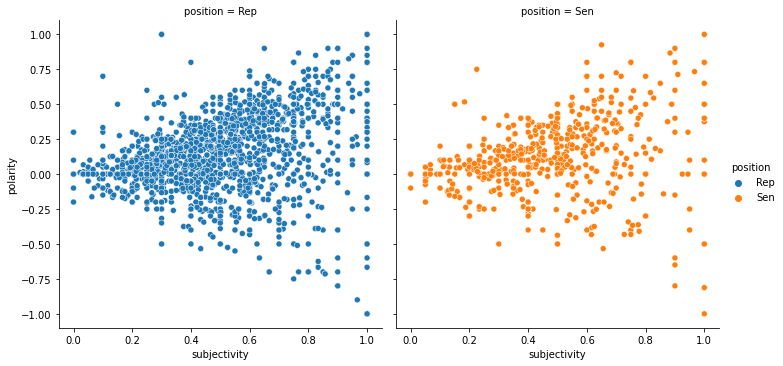

In [173]:
sns.relplot(
    data=ct_sub, x="subjectivity", y="polarity",
    col="position", hue = "position", kind="scatter"
)
plt.show()

<b>What do we see?</b>
Again, we see this same pattern. As tweets become mroe subjective, they also become more positive. The slight differences we see here are likely due to the composition of either chamber. For the 116th Congress, the Senate was majority Republican and the House was majority Democrat.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [174]:
ct_sub.columns

Index(['datetime', 'text', 'name_wikipedia', 'position',
       'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_str', 'wordcloud',
       'word_count', 'polarity', 'subjectivity'],
      dtype='object')

### Engineered Text Features

In [207]:
# Engineered Features, including wordcloud, word count, polarity and subjectivity
engineered_features = ct_sub[['word_count','polarity', 'subjectivity']].reset_index(drop = True)

In [209]:
engineered_features

,word_count,polarity,subjectivity
0,72,0.283333,0.491667
1,18,-0.333333,0.666667
2,24,0.500000,0.500000
3,43,-0.437500,0.500000
4,12,0.000000,0.000000
...,...,...,...
2995,25,0.100000,0.950000
2996,56,0.003333,0.441111
2997,34,0.133333,0.333333
2998,25,0.400000,0.775000


### Bag-of-words or Tf-idf

In [177]:
# Frequency Based featurization

# tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

### Word Embedding

In [178]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [179]:
import numpy as np
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model.wv._getitem_(doc), axis=0)

In [180]:
# embedding based featurization
model = gensim.models.Word2Vec(ct_sub['tokens'], size = 100, window = 5, \
                              min_count = 5, sg = 0, alpha = 0.025, iter = 5, batch_words = 10000)

In [181]:
model.wv.vocab

{'Before': <gensim.models.keyedvectors.Vocab at 0x7faf400dc410>,
 'spent': <gensim.models.keyedvectors.Vocab at 0x7fae93bec090>,
 'great': <gensim.models.keyedvectors.Vocab at 0x7fae93bec110>,
 'time': <gensim.models.keyedvectors.Vocab at 0x7fae93bec150>,
 'learning': <gensim.models.keyedvectors.Vocab at 0x7fae93bec1d0>,
 'Arizona': <gensim.models.keyedvectors.Vocab at 0x7fae93bec250>,
 'care': <gensim.models.keyedvectors.Vocab at 0x7fae93bec290>,
 'system': <gensim.models.keyedvectors.Vocab at 0x7fae93bec2d0>,
 'different': <gensim.models.keyedvectors.Vocab at 0x7fae93bec190>,
 'available': <gensim.models.keyedvectors.Vocab at 0x7fae93bec210>,
 'child': <gensim.models.keyedvectors.Vocab at 0x7fae93bec310>,
 'I': <gensim.models.keyedvectors.Vocab at 0x7fae93bec350>,
 'pleased': <gensim.models.keyedvectors.Vocab at 0x7fae93bec390>,
 'Administration': <gensim.models.keyedvectors.Vocab at 0x7fae93bec3d0>,
 'action': <gensim.models.keyedvectors.Vocab at 0x7fae93bec410>,
 'support': <gensim

In [182]:
doc = [word for word in ct_sub.reset_index()['tokens'][0] if word in model.wv.vocab]
len(doc)

30

In [193]:
doc[0:5]

['Before', 'spent', 'great', 'time', 'learning']

In [194]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return numpy.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [197]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for puppy in ct_sub['tokens_str']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, puppy))
    
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array 

In [198]:
doc_average_embeddings

array([[-0.08182182, -0.6302307 , -0.19854261, ...,  0.45068708,
         0.14533941,  0.12303196],
       [-0.09929196, -0.7653454 , -0.24213982, ...,  0.55079037,
         0.17731702,  0.15093961],
       [-0.09329654, -0.72627074, -0.22965954, ...,  0.52036923,
         0.16835125,  0.14136152],
       ...,
       [-0.09704276, -0.7471035 , -0.23653613, ...,  0.537556  ,
         0.17336631,  0.14648756],
       [-0.07113832, -0.54849786, -0.17275174, ...,  0.39213827,
         0.12646742,  0.10694495],
       [-0.09737077, -0.7494878 , -0.23672093, ...,  0.5378387 ,
         0.17416432,  0.14735691]], dtype=float32)

In [199]:
dae_df = pd.DataFrame(doc_average_embeddings)

In [200]:
dae_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.081822,-0.630231,-0.198543,-0.221500,-0.007064,-0.299108,-0.087126,-0.005631,-0.149984,0.275168,...,-0.177587,-0.065608,-0.005167,-0.052688,-0.600121,-0.044510,-0.456311,0.450687,0.145339,0.123032
1,-0.099292,-0.765345,-0.242140,-0.268871,-0.009678,-0.362800,-0.105295,-0.007768,-0.182657,0.334713,...,-0.216858,-0.079831,-0.005008,-0.064134,-0.730255,-0.053820,-0.553933,0.550790,0.177317,0.150940
2,-0.093297,-0.726271,-0.229660,-0.255276,-0.009049,-0.345446,-0.100586,-0.006519,-0.174410,0.317201,...,-0.204820,-0.076617,-0.006392,-0.060119,-0.692521,-0.050382,-0.525302,0.520369,0.168351,0.141362
3,-0.098405,-0.756973,-0.239173,-0.265477,-0.008933,-0.359289,-0.104687,-0.006810,-0.180576,0.330342,...,-0.213346,-0.079390,-0.005593,-0.062914,-0.721567,-0.053495,-0.548185,0.542489,0.175279,0.148617
4,-0.092654,-0.714192,-0.226285,-0.250599,-0.009522,-0.339150,-0.098677,-0.006237,-0.171334,0.311942,...,-0.201402,-0.075581,-0.005204,-0.058409,-0.681434,-0.049394,-0.515778,0.513409,0.166219,0.139578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.085866,-0.658641,-0.206861,-0.231167,-0.006791,-0.312245,-0.091112,-0.005087,-0.156668,0.287131,...,-0.184565,-0.068848,-0.004310,-0.054914,-0.628267,-0.047092,-0.477984,0.470689,0.152258,0.129554
2996,-0.086943,-0.670641,-0.210849,-0.235477,-0.007785,-0.318114,-0.093039,-0.005277,-0.159436,0.292529,...,-0.188603,-0.070410,-0.005172,-0.055943,-0.638944,-0.047827,-0.486129,0.478846,0.155079,0.131314
2997,-0.097043,-0.747104,-0.236536,-0.262830,-0.009872,-0.354582,-0.102975,-0.007666,-0.179054,0.326098,...,-0.211672,-0.078619,-0.005262,-0.062171,-0.711919,-0.051835,-0.539906,0.537556,0.173366,0.146488
2998,-0.071138,-0.548498,-0.172752,-0.193043,-0.006521,-0.260342,-0.075533,-0.005048,-0.130513,0.239080,...,-0.155161,-0.056662,-0.004535,-0.046058,-0.521359,-0.038613,-0.396585,0.392138,0.126467,0.106945


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [187]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud,word_count,polarity,subjectivity
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,72,0.283333,0.491667
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,18,-0.333333,0.666667
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,24,0.500000,0.500000
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,43,-0.437500,0.500000
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,12,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,25,0.100000,0.950000
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,56,0.003333,0.441111
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,34,0.133333,0.333333
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,"2,089,104","1,877,963","1,773,827","2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,25,0.400000,0.775000


Creat a column with only Democrats and Republicans

In [188]:
ct_sub['DR'] = ct_sub['party']. apply(lambda x : 0 if x =='Democrat' and x!='Independent' else 1)

In [189]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,wordcloud,word_count,polarity,subjectivity,DR
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,...,"1,161,167","1,025,232","1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,72,0.283333,0.491667,1
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,...,"4,556,118","4,485,741","2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,18,-0.333333,0.666667,0
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,...,"2,394,164","2,827,709","2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,24,0.500000,0.500000,1
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,...,"189,765","212,787","420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,43,-0.437500,0.500000,1
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,...,"628,854","679,370","1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,12,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,...,"3,090,729","3,019,512","2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,25,0.100000,0.950000,0
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,...,"4,556,118","4,485,741","2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,56,0.003333,0.441111,0
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,...,"4,556,118","4,485,741","2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,34,0.133333,0.333333,1
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,...,"1,877,963","1,773,827","2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,25,0.400000,0.775000,1


Join dataframes together

In [210]:
dataframes = [engineered_features,
                    topic_dist_df, 
                    tfidf_df]

featurization_technique = ['Engineered Text Features', 
                            'Topic Model',
                             'Tf-idf Features']


In [202]:
# binarize label
lb_style = LabelBinarizer()
y = ct_sub['party_binary'] = lb_style.fit_transform(ct_sub['DR'])


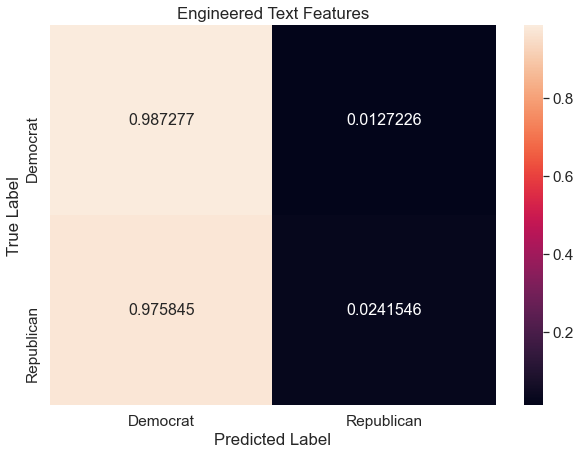

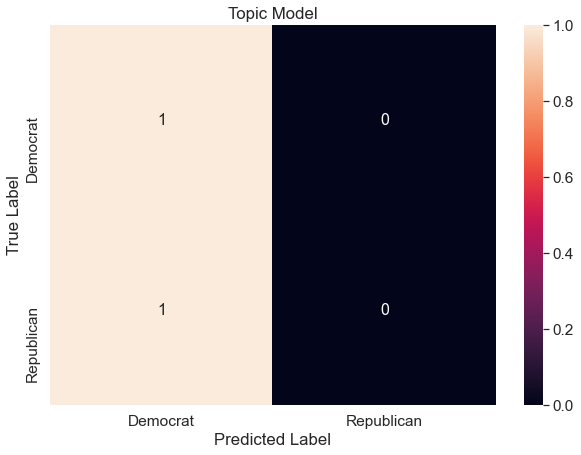

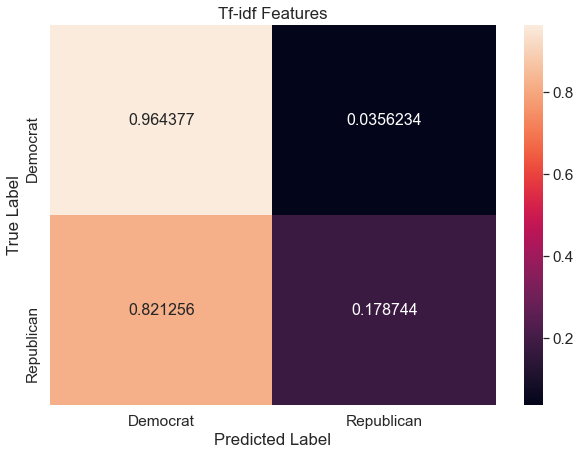

In [215]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [217]:
y2 = ct_sub['position_binary'] = lb_style.fit_transform(ct_sub['position'])

In [218]:
ct_sub

,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,...,romney_2012_state_share,tokens,tokens_str,wordcloud,word_count,polarity,subjectivity,DR,party_binary,position_binary
36257,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,...,"1,233,654","[Before, adopting, Olivia, spent, great, time,...",Before adopting Olivia spent great time learni...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,72,0.283333,0.491667,1,1,0
548996,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,...,"2,490,431","[Are, supposed, Trump, seriously, literally, s...",Are supposed Trump seriously literally steel b...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,18,-0.333333,0.666667,0,0,0
652347,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,...,"2,661,437","[Thank, Lieutenant, Mike, Tarr, Fire, Chief, O...",Thank Lieutenant Mike Tarr Fire Chief Ott Hube...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,24,0.500000,0.500000,1,1,0
267614,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,...,"420,911","[Made, remarks, AmFreeSyria, sharing, concern,...",Made remarks AmFreeSyria sharing concern devas...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,43,-0.437500,0.500000,1,1,1
344386,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,...,"1,087,190","[jeroneanderson, MontcoLP, LelandShow, realDon...",jeroneanderson MontcoLP LelandShow realDonaldT...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,12,0.000000,0.000000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289949,2019-12-20T09:38:54-05:00,That’s one reason why I’m proud to have secure...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,...,"2,135,216","[That, reason, I, proud, secured, provisions, ...",That reason I proud secured provisions NDAA he...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,25,0.100000,0.950000,0,0,1
590720,2020-05-07T15:20:53-04:00,"We need more funds for #EIDL and, in meantime,...",Nydia Velázquez,Rep,3-Jan-13,3/28/1953,F,NY,7,Democrat,...,"2,490,431","[We, need, funds, EIDL, meantime, SBAGov, queu...",We need funds EIDL meantime SBAGov queue loan ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,56,0.003333,0.441111,0,0,0
601127,2020-09-04T09:49:40-04:00,A strong US economic recovery is well underway...,Lee Zeldin,Rep,3-Jan-15,1/30/1980,M,NY,1,Republican,...,"2,490,431","[A, strong, US, economic, recovery, underway, ...",A strong US economic recovery underway faster ...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,34,0.133333,0.333333,1,1,0
264039,2020-08-25T16:22:34-04:00,The Savannah Harbor Expansion Project is on tr...,David Perdue,Sen,3-Jan-15,12/10/1949,M,GA,Senate,Republican,...,"2,078,688","[The, Savannah, Harbor, Expansion, Project, tr...",The Savannah Harbor Expansion Project track co...,<wordcloud.wordcloud.WordCloud object at 0x7fa...,25,0.400000,0.775000,1,1,1


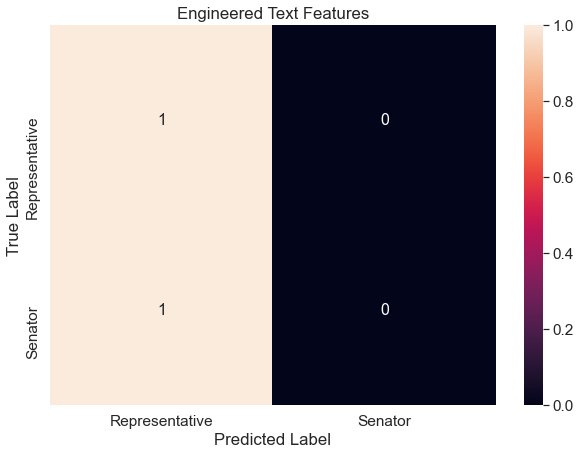

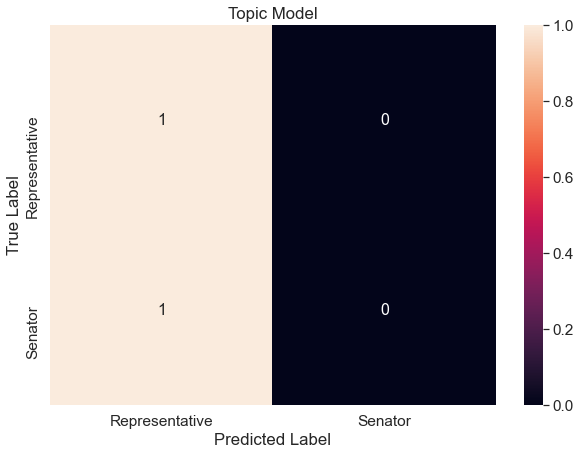

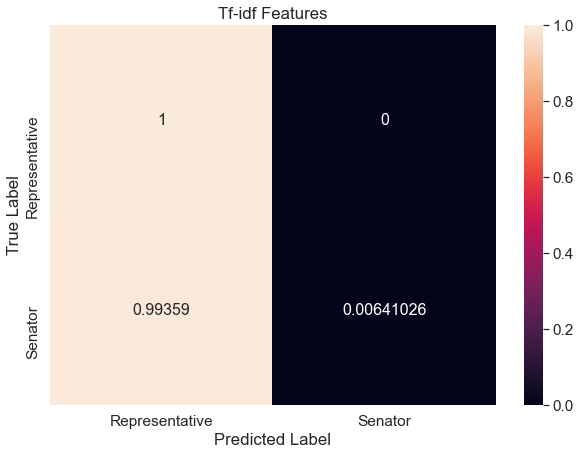

In [219]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X2_train, X2_test, y2_train, y2_test = train_test_split(dataframe, 
                                                        y2, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X2_train, y2_train.ravel())

    y2_pred = logit_model.predict(X2_test)
    
    cf_matrix = confusion_matrix(y2_test, y2_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**